In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime


# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# read in CSV file data
df = pd.read_csv('reviews.csv')


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\envs\tpsxsv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


### Look at my data
1. How many rows are in the dataset?
2. How many columns are in this dataset?
3. What data types are the columns?
4. Is the data complete? Are there nulls? Do we have to infer values?
5. Whhat is the definition of these columns?
6. What are some other caveats to the data?

In [2]:
# look at data
display(df.head())

# look a shape of data
display(df.shape)

# look at data types. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].dtypes)

# see if any columns have nulls. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].isnull().any())

# display descriptive statistics
display(df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,2708,2014-06-09
3,2708,2014-06-23
4,2708,2015-07-25


(1511891, 2)

listing_id     int64
date          object
dtype: object

listing_id    False
date          False
dtype: bool

,listing_id
count,1.511891e+06
mean,6.652071e+15
std,6.155726e+16
min,1.090000e+02
25%,9.033317e+06
50%,2.027901e+07
75%,3.437049e+07
85%,4.229661e+07
95%,5.097231e+07
99%,5.494387e+17


## Techniques may help answer time series- forecasting?
### Statistical models
*   **Ignore the time-series aspect completely and model using traditional statistical modeling toolbox.** 
  *   *Examples.* Regression-based models.  
*   **Univariate statistical time-series modeling.**
  *   *Examples.* Averaging and smoothing models, ARIMA models.
*   **Slight modifications to univariate statistical time-series modeling.**
  *    *Examples.* External regressors, multi-variate models.
*   **Additive or component models.**
  *  *Examples.* Facebook Prophet package.
*   **Structural time series modeling.**
  *    *Examples.* Bayesian structural time series modeling, hierarchical time series modeling.

### Machine learning models

*   **Ignore the time-series aspect completely and model using traditional machine learning modeling toolbox.** 
  *   *Examples.* Support Vector Machines (SVMs), Random Forest Regression, Gradient-Boosted Decision Trees (GBDTs).
*   **Hidden markov models (HMMs).**
*   **Other sequence-based models.**
*   **Gaussian processes (GPs).**
*   **Recurrent neural networks (RNNs).**
  
### Additional data considerations before choosing a model
*   Whether or not to incorporate external data
*   Whether or not to keep as univariate or multivariate (i.e., which features and number of features)
*   Outlier detection and removal
*   Missing value imputation

## Process the data

In [3]:
# Rename columns
df = df.rename(columns = {'date': 'ds', 'listing_id': 'ts'})

# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})

# Change index to datetime
df_example.index = pd.to_datetime(df_example.index)

# Set frequency of time series
df_example = df_example.asfreq(freq='1D')

# Sort the values
df_example = df_example.sort_index(ascending = True)

# Fill values with 0
df_example = df_example.fillna(value = 0)

# Show the end of the data
display(df_example.tail())

,ts
ds,
2022-06-02,532.0
2022-06-03,561.0
2022-06-04,481.0
2022-06-05,527.0
2022-06-06,7.0


## Plot my data
- There does appear to be an overall increasing trend. 
- There appears to be some differences in the variance over time. 
- There may be some seasonality (i.e., cycles) in the data.
- Not sure about outliers.

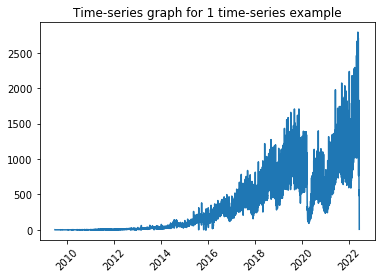

In [4]:
# Plot time series data
f, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])

# Add title
ax.set_title('Time-series graph for 1 time-series example')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.show()
plt.close()

## Look at stationarity
Most time-series models assume that the underlying time-series data is **stationary**.  This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past.  This general statement holds for most training data and modeling tasks.

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\ProgramData\Anaconda3\envs\tpsxsv\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


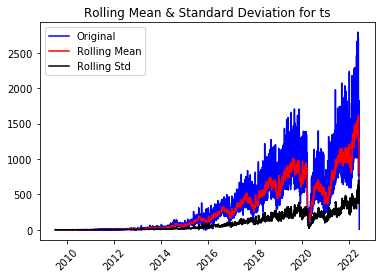

Results of Dickey-Fuller Test:
Test Statistic                   -2.273667
p-value                           0.180602
# Lags Used                      32.000000
Number of Observations Used    4698.000000
Critical Value (1%)              -3.431743
Critical Value (5%)              -2.862155
Critical Value (10%)             -2.567098
dtype: float64


In [6]:
test_stationarity(df = df_example, ts = 'ts')

**Looking at our data:**
- Rolling mean and standard deviation look like they change over time.  There may be some de-trending and removing seasonality involved. Based on **Dickey-Fuller test**, because p = 0.18, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our **time series is not stationary**.

## Correct for stationarity

It is common for time series data to have to correct for non-stationarity. 

2 common reasons behind non-stationarity are:

1. **Trend** – mean is not constant over time.
2. **Seasonality** – variance is not constant over time.

There are ways to correct for trend and seasonality, to make the time series stationary.

## Eliminating trend and seasonality
*   **Transformation**
  *   *Examples.* Log, square root, etc.
  *   We are going to look at log.
*   **Smoothing**
  *  *Examples.* Weekly average, monthly average, rolling averages.
  *   We are going to look at weekly average.
*   **Differencing**
  *  *Examples.* First-order differencing.
  *   We are going to look at first-order differencing.
*   **Polynomial Fitting**
  *  *Examples.* Fit a regression model.
*   **Decomposition**

## Transformation, Smoothing, and Differencing
**Looking at our data:**
- Applying log transformation, weekly moving average smoothing, and differencing made the data more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [7]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subplots(1,1)
  ax.plot(df[ts])
  ax.plot(df[ts_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([ts, ts_transform])
  
  plt.show()
  plt.close()
  
  return

C:\ProgramData\Anaconda3\envs\tpsxsv\lib\site-packages\pandas\core\algorithms.py:1547: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]
C:\ProgramData\Anaconda3\envs\tpsxsv\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\envs\tpsxsv\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2010-10-06,2.0,0.693147,0.396084,1.571429,0.000000,0.428571,0.297063,0.693147,0.000000
2010-11-09,1.0,0.000000,0.198042,1.285714,-0.693147,-0.285714,-0.198042,0.329429,-0.329429
2010-11-10,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.208584,-0.208584
2010-11-11,2.0,0.693147,0.198042,1.285714,0.693147,0.714286,0.495105,0.348266,0.344881
2010-11-12,1.0,0.000000,0.198042,1.285714,-0.693147,-0.285714,-0.198042,0.264184,-0.264184


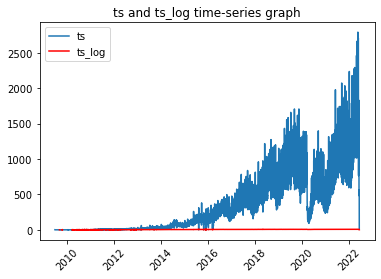

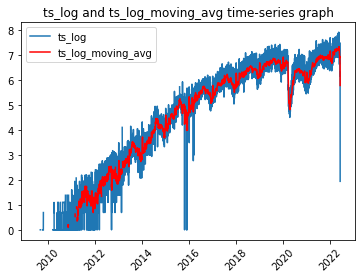

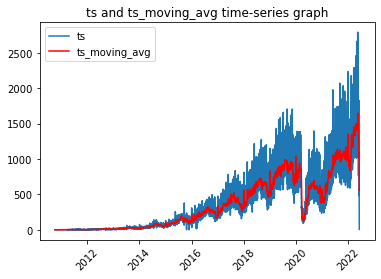

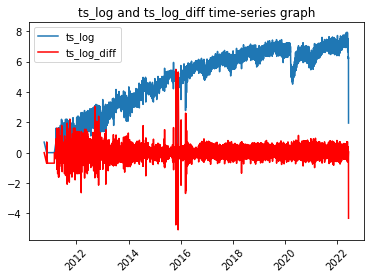

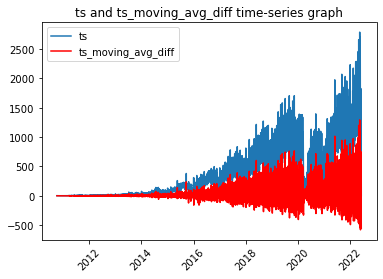

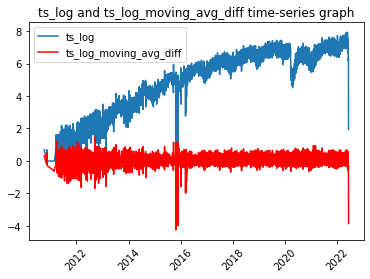

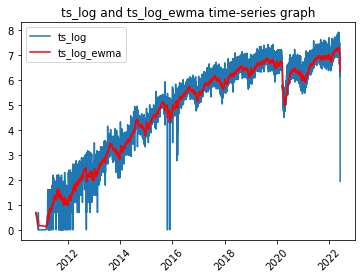

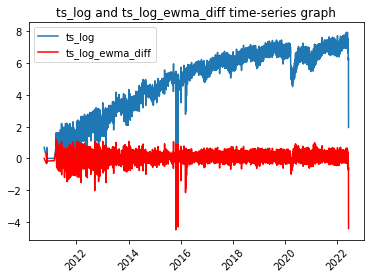

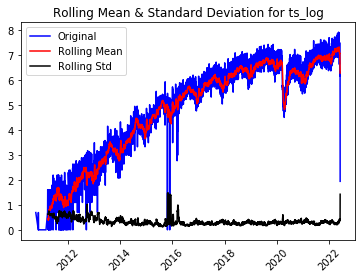

Results of Dickey-Fuller Test:
Test Statistic                   -2.309470
p-value                           0.168932
# Lags Used                      31.000000
Number of Observations Used    3927.000000
Critical Value (1%)              -3.432016
Critical Value (5%)              -2.862276
Critical Value (10%)             -2.567162
dtype: float64


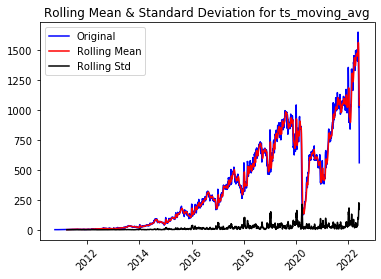

Results of Dickey-Fuller Test:
Test Statistic                   -2.280875
p-value                           0.178210
# Lags Used                      30.000000
Number of Observations Used    3928.000000
Critical Value (1%)              -3.432016
Critical Value (5%)              -2.862276
Critical Value (10%)             -2.567162
dtype: float64


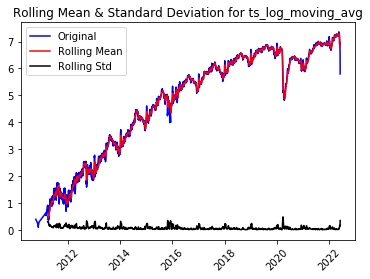

Results of Dickey-Fuller Test:
Test Statistic                   -2.220887
p-value                           0.198752
# Lags Used                      30.000000
Number of Observations Used    3928.000000
Critical Value (1%)              -3.432016
Critical Value (5%)              -2.862276
Critical Value (10%)             -2.567162
dtype: float64


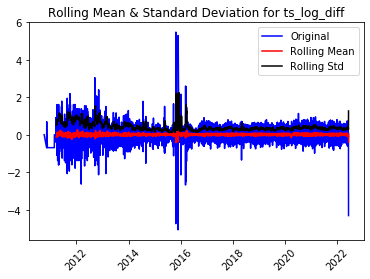

Results of Dickey-Fuller Test:
Test Statistic                -1.074948e+01
p-value                        2.688266e-19
# Lags Used                    3.000000e+01
Number of Observations Used    3.928000e+03
Critical Value (1%)           -3.432016e+00
Critical Value (5%)           -2.862276e+00
Critical Value (10%)          -2.567162e+00
dtype: float64


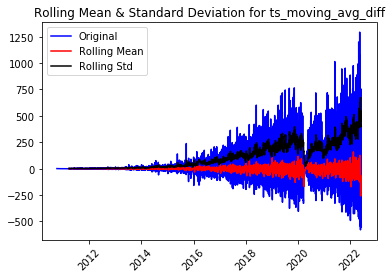

Results of Dickey-Fuller Test:
Test Statistic                -9.281317e+00
p-value                        1.248910e-15
# Lags Used                    2.800000e+01
Number of Observations Used    3.930000e+03
Critical Value (1%)           -3.432015e+00
Critical Value (5%)           -2.862276e+00
Critical Value (10%)          -2.567162e+00
dtype: float64


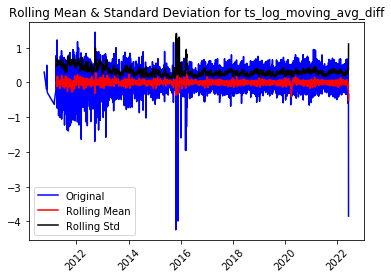

Results of Dickey-Fuller Test:
Test Statistic                -1.139965e+01
p-value                        7.704195e-21
# Lags Used                    3.100000e+01
Number of Observations Used    3.927000e+03
Critical Value (1%)           -3.432016e+00
Critical Value (5%)           -2.862276e+00
Critical Value (10%)          -2.567162e+00
dtype: float64


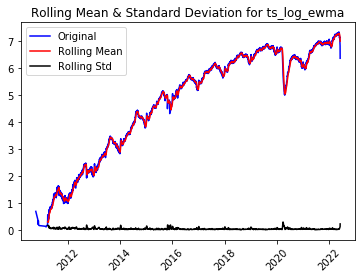

Results of Dickey-Fuller Test:
Test Statistic                   -2.361281
p-value                           0.152964
# Lags Used                      31.000000
Number of Observations Used    3927.000000
Critical Value (1%)              -3.432016
Critical Value (5%)              -2.862276
Critical Value (10%)             -2.567162
dtype: float64


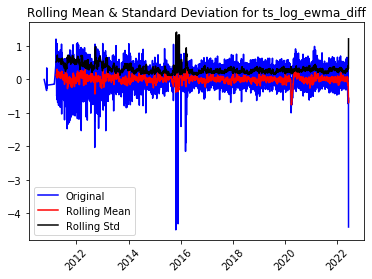

Results of Dickey-Fuller Test:
Test Statistic                -9.268777e+00
p-value                        1.344380e-15
# Lags Used                    3.100000e+01
Number of Observations Used    3.927000e+03
Critical Value (1%)           -3.432016e+00
Critical Value (5%)           -2.862276e+00
Critical Value (10%)          -2.567162e+00
dtype: float64


In [8]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example_transform = df_example.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']

# Display data
display(df_example_transform.head())

# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

## Decomposition: trend, seasonality, residuals
**Looking at our data:**
- De-trending and de-seasonalizing made the data (i.e., the residuals) more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [9]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

C:\ProgramData\Anaconda3\envs\tpsxsv\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\tpsxsv\lib\site-packages\pandas\core\indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


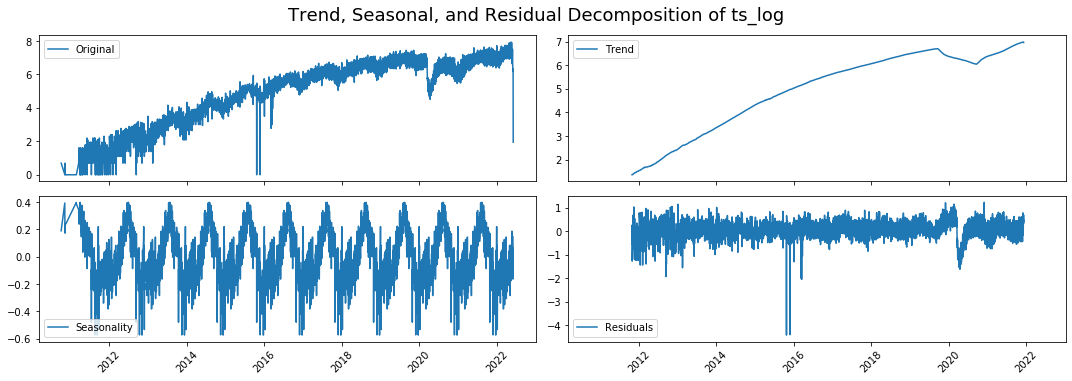

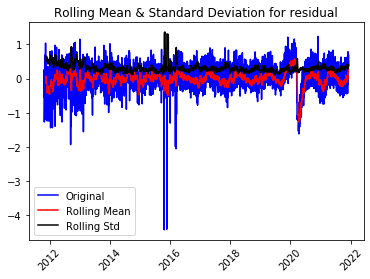

Results of Dickey-Fuller Test:
Test Statistic                -6.695422e+00
p-value                        4.011042e-09
# Lags Used                    3.000000e+01
Number of Observations Used    3.564000e+03
Critical Value (1%)           -3.432186e+00
Critical Value (5%)           -2.862351e+00
Critical Value (10%)          -2.567202e+00
dtype: float64


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')

# Let us model some time-series data! Finally! ARIMA models.

We will be doing an example here! We can use ARIMA models when we know there is dependence between values and we can leverage that information to forecast.

**ARIMA = Auto-Regressive Integrated Moving Average**.   
**Assumptions.** The time-series is stationary.  
**Depends on:**  
  **1. Number of AR (Auto-Regressive) terms (p).**  
  **2. Number of I (Integrated or Difference) terms (d).**  
  **3. Number of MA (Moving Average) terms (q).**  

# ACF and PACF Plots
**How do we determine p, d, and q?**
For p and q, we can use ACF and PACF plots (below).

**Autocorrelation Function (ACF).** Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

**Partial Autocorrelation Function (PACF).** Additional correlation explained by each successive lagged term.

**How do we interpret ACF and PACF plots?**
- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.


In [11]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

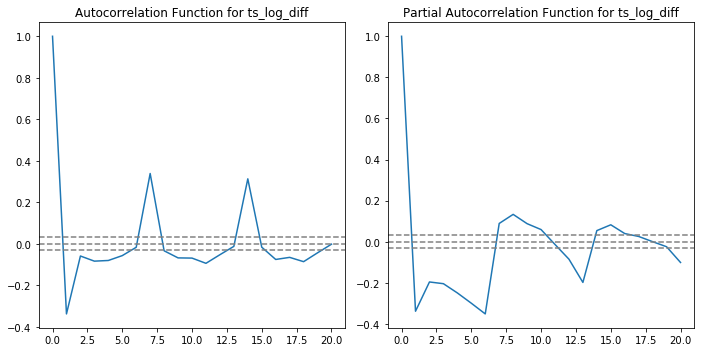

In [12]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(df_example_transform['ts_log_diff']), nlags = 20)
lag_pacf = pacf(np.array(df_example_transform['ts_log_diff']), nlags = 20)

# plot ACF and PACF
plot_acf_pacf(df = df_example_transform, ts = 'ts_log_diff')

In [13]:
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima_model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.show()
  plt.close()
  
  return results_

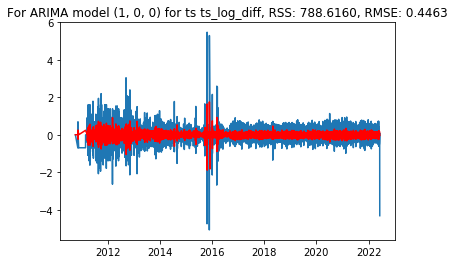

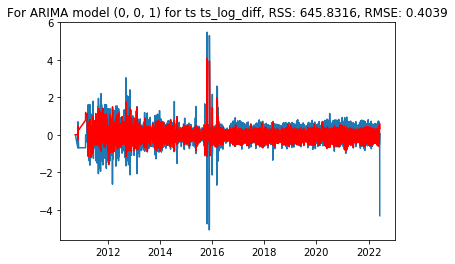

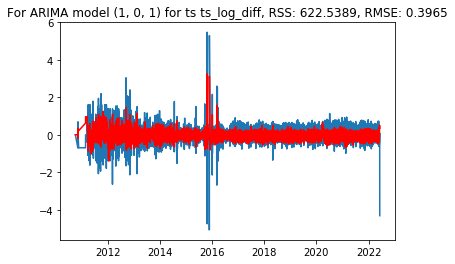

In [14]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_MA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_ARMA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)